In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import csv
import random
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from keras.models import Sequential, load_model
from keras.applications.vgg19 import VGG19
from keras.layers import BatchNormalization, Dense, Flatten, Dropout
from time import time

np.random.seed(42)

In [12]:
# Extracting data
data_dir = os.getcwd()
train_path = data_dir + '/Train'
test_path = data_dir + '/'

# Resizing the images to 32x32x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3



In [13]:
# Finding total classes
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [14]:
# Defining Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

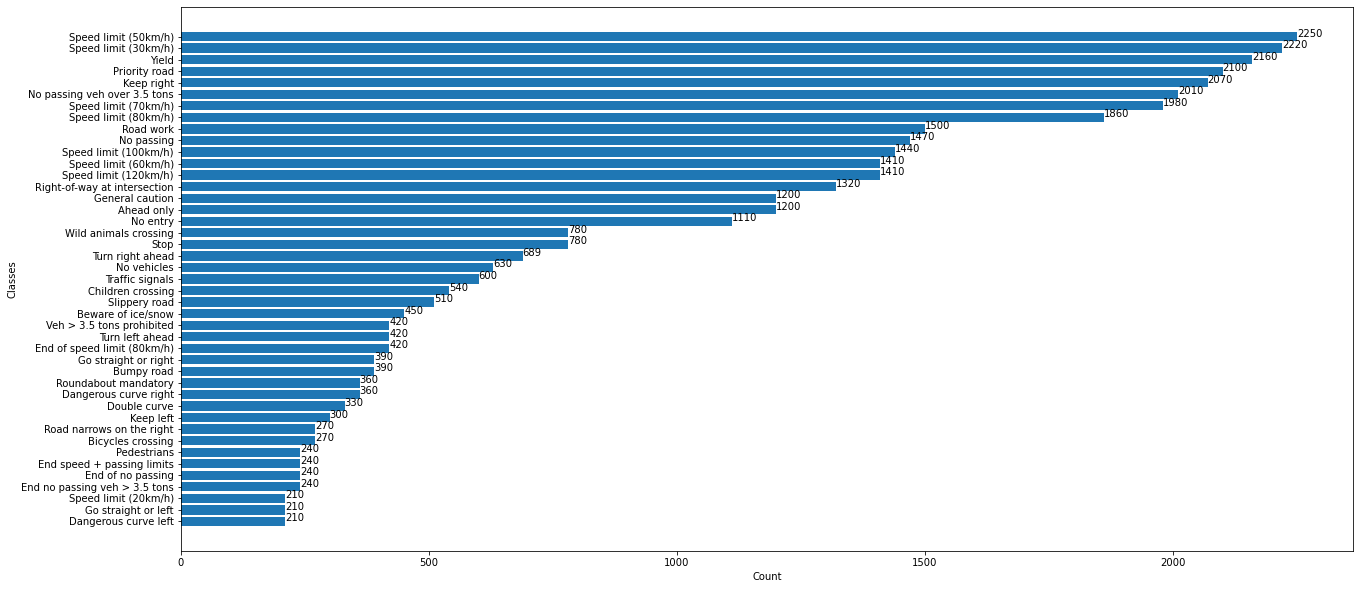

In [15]:
# Visualizing the dataset
folders = os.listdir(train_path)

train_number = []
class_names = []

for folder in folders:
    
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_names.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_names)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_names = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.barh(class_names, train_number)
plt.yticks(class_names)
plt.xlabel('Count')
plt.ylabel('Classes')
for index, value in enumerate(train_number):
    plt.text(value, index,
             str(value))
plt.show()

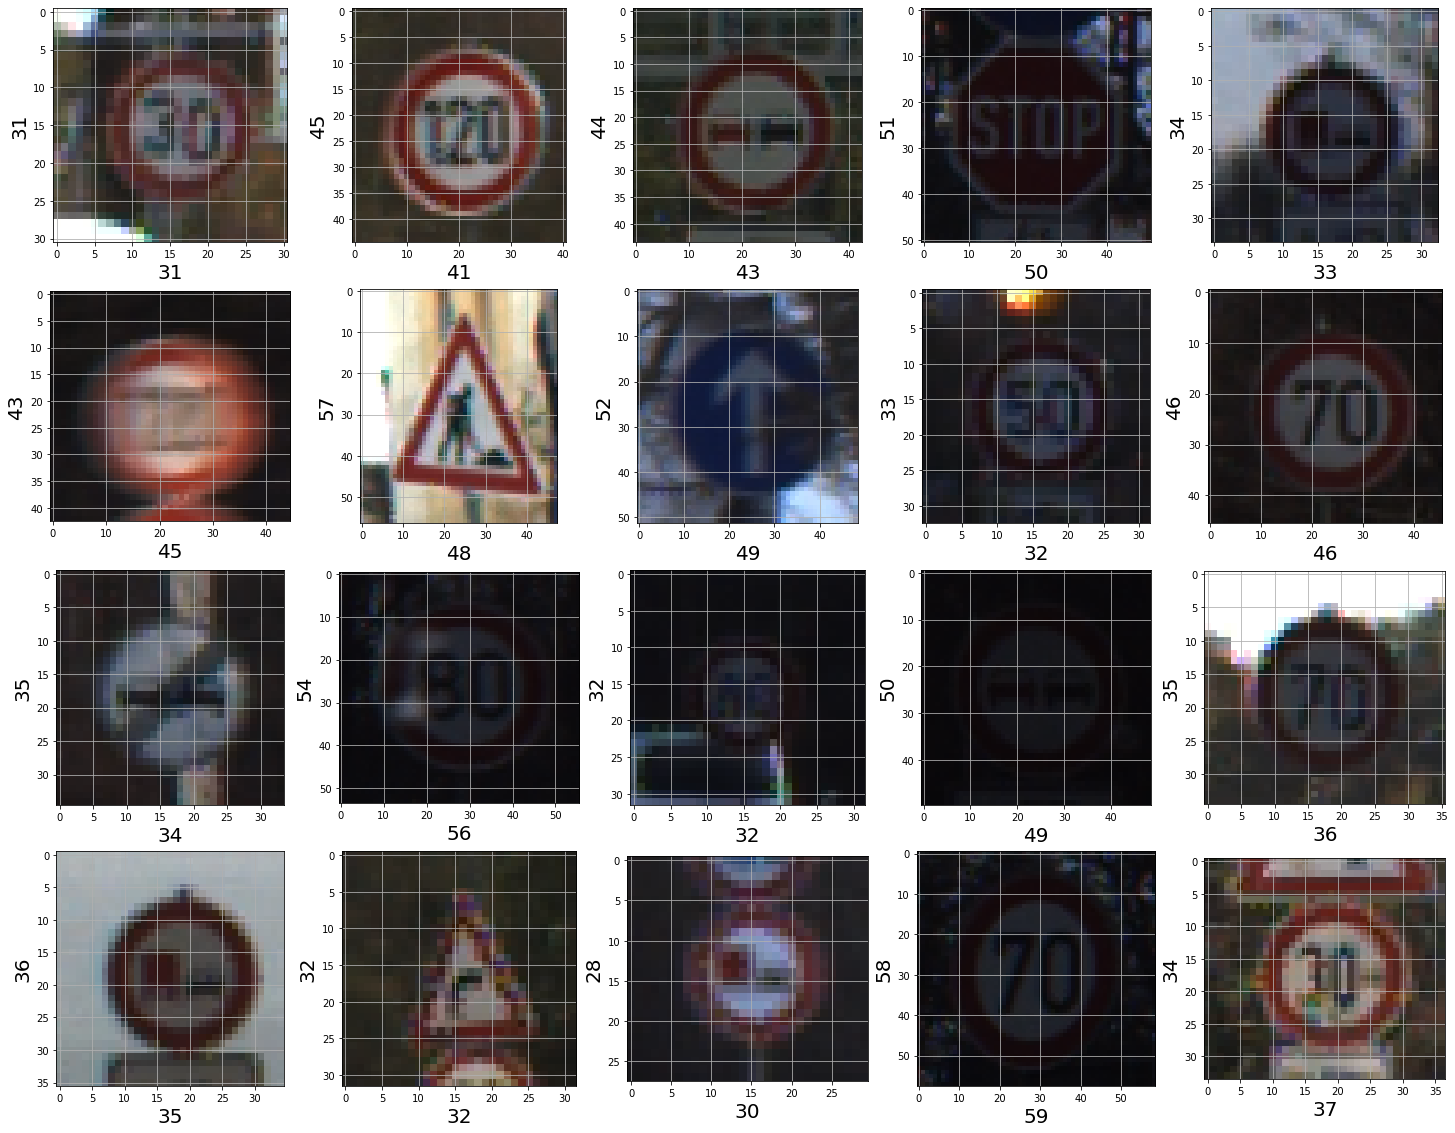

In [16]:
# Data Visualizing random images from the test data
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,21):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [17]:
# Basic preprocessing and mixing of dataset
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

In [18]:
start = time()

train_images, train_labels = load_train(data_dir + "/", 32)
test_images, test_labels = load_test(data_dir + "/", 32)
shape = train_images[0].shape
print(shape)

# normalizing the images data
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

# One-hot encoding the labels 
train_labels = to_categorical(train_labels, NUM_CATEGORIES)
test_labels = to_categorical(test_labels, NUM_CATEGORIES)

print('Loading: ', time() - start)

(32, 32, 3)
Loading:  13.107579231262207


In [19]:
# Splitting th dataset
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, shuffle=True)

print("X_train.shape - ", X_train.shape)
print("X_valid.shape - ", X_val.shape)
print("y_train.shape - ", y_train.shape)
print("y_valid.shape - ", y_val.shape)

X_train.shape -  (31367, 32, 32, 3)
X_valid.shape -  (7842, 32, 32, 3)
y_train.shape -  (31367, 43)
y_valid.shape -  (7842, 43)


In [20]:
# Image augmentation for better performance
train_image_aug = ImageDataGenerator(
                            rotation_range=10,
                            zoom_range=0.15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.15,
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode="nearest")

# Applying data augmentation to features
BATCH_SIZE= 128
train_gen = train_image_aug.flow(X_train, y_train, batch_size= BATCH_SIZE)

In [21]:
# Creating model with VGG19 base (transfer learning)
vgg_conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(32,32,3)) 

vgg_model = Sequential()
vgg_model.add(vgg_conv_base)
vgg_model.add(BatchNormalization())
vgg_model.add(Flatten())
vgg_model.add(Dense(1024, activation='relu'))
vgg_model.add(Dropout(rate=0.5))
vgg_model.add(Dense(NUM_CATEGORIES, activation='softmax'))

80150528/80134624 [==============================] - 3s 0us/step


In [22]:
LR = 0.0001 # learning rate
EPOCHS = 10

opt = Adam(lr=LR)

# Compiling the model
vgg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\USER\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
# Model summary
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 43)                44075     
                                                        

In [24]:
# Model training
history = vgg_model.fit(train_gen, epochs=EPOCHS, validation_data=(X_val, y_val), shuffle= True)

# Saving model
vgg_model.save("trafficsignrecognition_model.h5")

Epoch 1/10
246/246 [==============================] - 1084s 4s/step - loss: 1.4545 - accuracy: 0.5973 - val_loss: 1.1827 - val_accuracy: 0.7886
Epoch 2/10
246/246 [==============================] - 1065s 4s/step - loss: 0.2202 - accuracy: 0.9374 - val_loss: 0.0848 - val_accuracy: 0.9772
Epoch 3/10
246/246 [==============================] - 914s 4s/step - loss: 0.0910 - accuracy: 0.9732 - val_loss: 0.0661 - val_accuracy: 0.9802
Epoch 4/10
246/246 [==============================] - 980s 4s/step - loss: 0.0583 - accuracy: 0.9831 - val_loss: 0.0705 - val_accuracy: 0.9768
Epoch 5/10
246/246 [==============================] - 1039s 4s/step - loss: 0.0500 - accuracy: 0.9852 - val_loss: 0.0252 - val_accuracy: 0.9938
Epoch 6/10
246/246 [==============================] - 978s 4s/step - loss: 0.0309 - accuracy: 0.9909 - val_loss: 0.0151 - val_accuracy: 0.9958
Epoch 7/10
246/246 [==============================] - 1039s 4s/step - loss: 0.0279 - accuracy: 0.9911 - val_loss: 0.0172 - val_accuracy: 0.

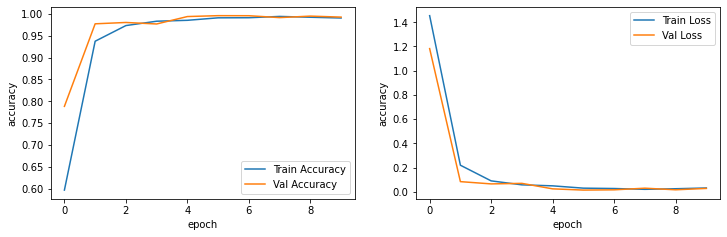

In [25]:
# Plotting the history 
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [26]:
# Model evaluation
test_loss, test_acc = vgg_model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

395/395 [==============================] - 34s 86ms/step - loss: 0.2337 - accuracy: 0.9528
Test accuracy: 0.9528107643127441
Test loss: 0.23369917273521423


In [27]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255


predict_x=vgg_model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  95.93824228028504


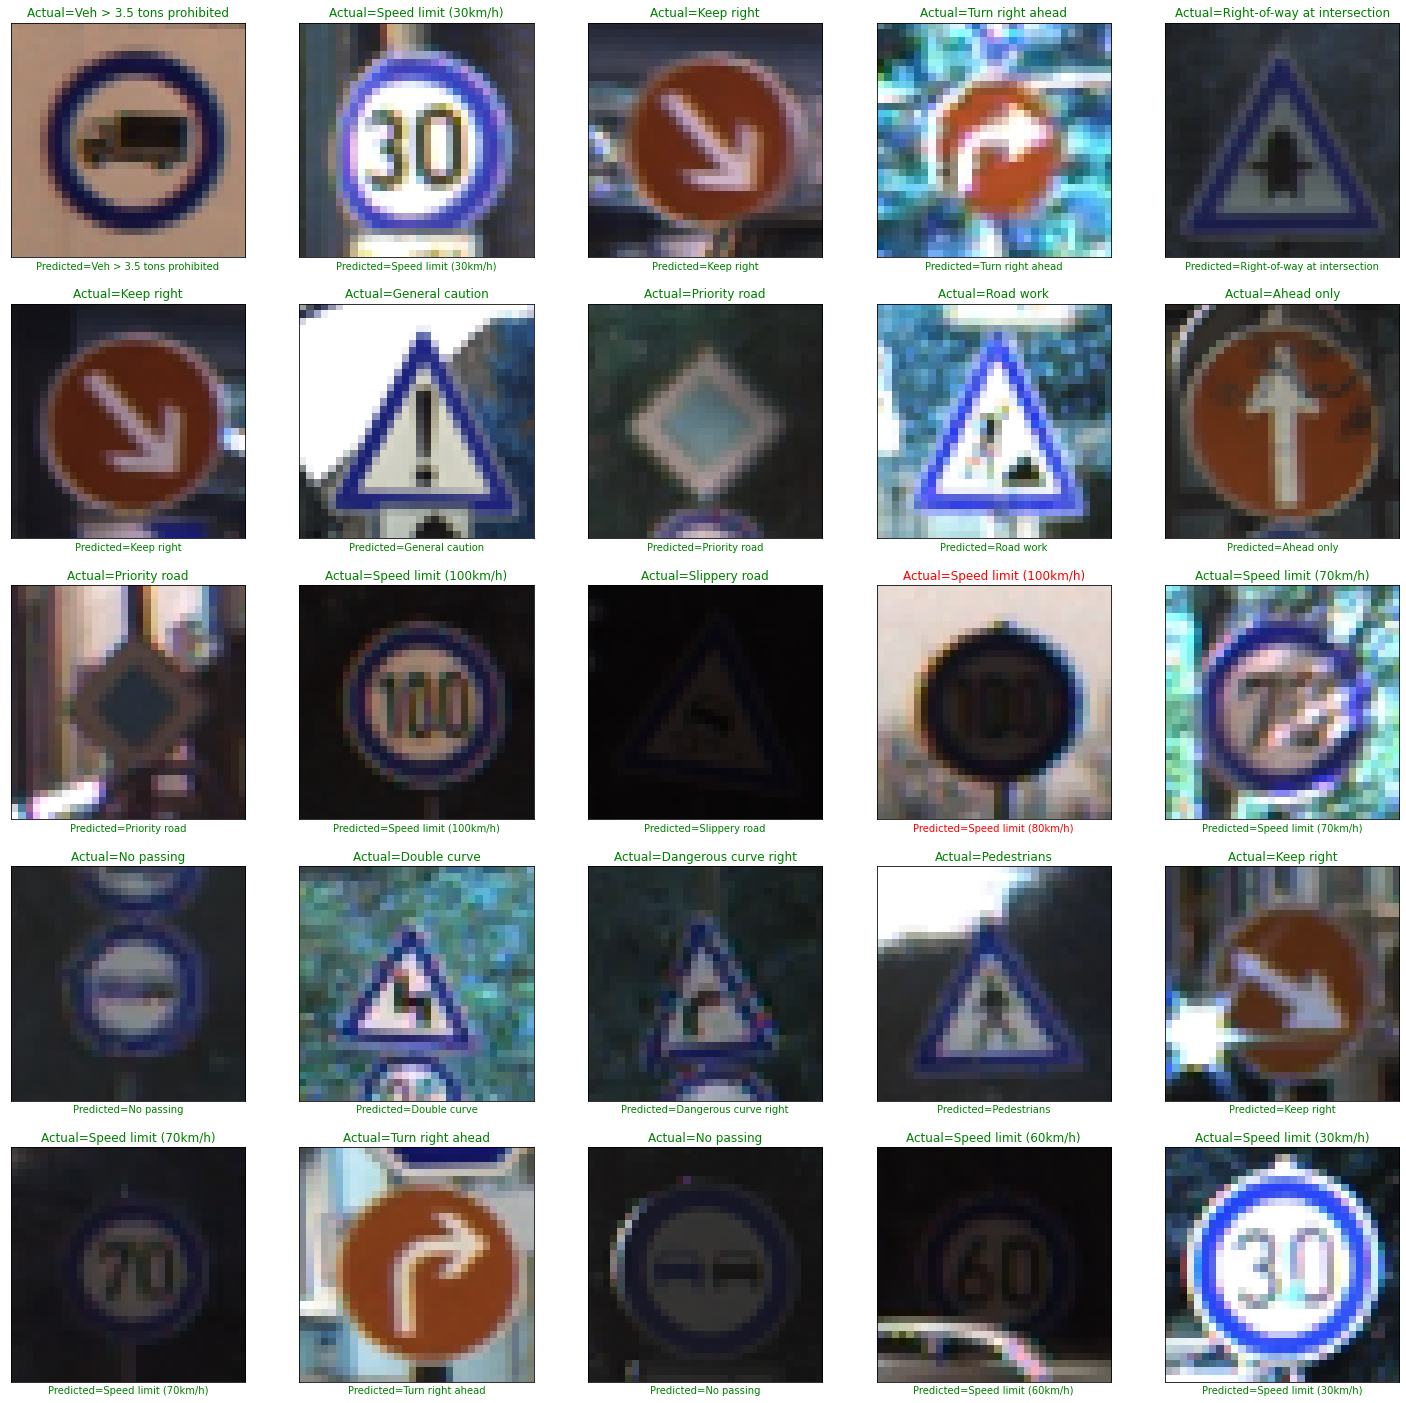

In [28]:
# Model prediction
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.title('Actual={}'.format(classes[int(actual)]), color = col)
    plt.xlabel('Predicted={}'.format(classes[int(prediction)]), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()